In [11]:
import pandas as pd
import nltk
import re
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.utils import resample

In [12]:
words = pd.read_csv("Cleaned_LM_Master_Dict.csv")
words = words.drop(columns=["Uncertainty"])
words

,Word,Negative,Positive
0,abandon,2009,0
1,abandoned,2009,0
2,abandoning,2009,0
3,abandonment,2009,0
4,abandonments,2009,0
...,...,...,...
2961,wrongdoing,2009,0
2962,wrongdoings,2009,0
2963,wrongful,2009,0
2964,wrongfully,2009,0


In [13]:
words.to_csv("Cleaned_LM_Master_Dict_Cleaned.csv", index=False)


In [17]:

tsla_path = "/Users/leoking/Desktop/finalprojectfile/TSLA_tweets_clean.csv"
nvda_path = "/Users/leoking/Desktop/finalprojectfile/NVDA_tweets_clean.csv"
fb_path = "/Users/leoking/Desktop/finalprojectfile/FB_tweets_clean.csv"
amzn_path = "/Users/leoking/Desktop/finalprojectfile/AMZN2019-2022_tweets_clean.csv"


tsla_df = pd.read_csv(tsla_path)
nvda_df = pd.read_csv(nvda_path)
fb_df = pd.read_csv(fb_path)
amzn_df = pd.read_csv(amzn_path)


combined_df = pd.concat([tsla_df, nvda_df, fb_df, amzn_df], ignore_index=True)

In [18]:
combined_df.shape


(2551018, 4)

In [19]:
combined_df


,Unnamed: 0,created_at,cleaned_body,company
0,2398854,2022-03-01 01:57:34+00:00,$tsla shorts \n \n tesla call putratio with ...,TSLA
1,2398855,2022-03-01 01:55:47+00:00,$tsla what are the chances of biden mentioning...,TSLA
2,2398856,2022-03-01 01:55:34+00:00,$arkk $zm $tsla $tdoc $coin \nso is cathie o...,TSLA
3,2398857,2022-03-01 01:48:43+00:00,$amc $tsla \n\ncant wait to buy a tesla for ov...,TSLA
4,2398858,2022-03-01 01:48:25+00:00,$tsla with future up now any guess what will h...,TSLA
...,...,...,...,...
2551013,1392144,2020-01-01 00:15:25+00:00,aapl achv acor admp adms $adxs $amba $amd $amr...,AMZN2019-2022
2551014,1392145,2020-01-01 00:13:41+00:00,$spy $amzn $nflx was wondering if moo could be...,AMZN2019-2022
2551015,1392146,2020-01-01 00:06:17+00:00,$amzn dow futures up by points already,AMZN2019-2022
2551016,1392147,2020-01-01 00:05:23+00:00,$amzn $shop im locked in and ready,AMZN2019-2022


In [20]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/leoking/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leoking/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

further cleaning 

droping duplicate

In [21]:
combined_df.drop_duplicates(subset=["cleaned_body"], inplace=True)
combined_df.shape

(2550978, 4)

handling missing values

In [8]:
combined_df.dropna(subset=["cleaned_body"], inplace=True)
combined_df.shape


(2550978, 4)

step 3 

In [22]:
# Tokenization is the process of breaking down a text into individual units, called tokens
#take each tweet and break it down into its constituent words
combined_df['tokenized_tweets'] = combined_df["cleaned_body"].apply(word_tokenize)


Step 4: Remove stopwords and special characters

In [23]:
stop_words = set(stopwords.words("english"))
combined_df["cleaned_tweets"] = combined_df["tokenized_tweets"].apply(lambda tokens: [word for word in tokens if word.isalnum() and word.lower() not in stop_words])

step 5: convert all text to lowercase

In [24]:
combined_df["cleaned_tweets"] = combined_df["cleaned_tweets"].apply(lambda tokens: [word.lower() for word in tokens])

In [25]:
print(combined_df[["cleaned_body", "cleaned_tweets"]].head())

                                        cleaned_body  \
0  $tsla shorts \n \n tesla call putratio   with ...   
1  $tsla what are the chances of biden mentioning...   
2   $arkk $zm $tsla $tdoc $coin  \nso is cathie o...   
3  $amc $tsla \n\ncant wait to buy a tesla for ov...   
4  $tsla with future up now any guess what will h...   

                                      cleaned_tweets  
0  [tsla, shorts, tesla, call, putratio, focus, m...  
1  [tsla, chances, biden, mentioning, tsla, speec...  
2  [arkk, zm, tsla, tdoc, coin, cathie, something...  
3  [amc, tsla, cant, wait, buy, tesla, overall, c...  
4            [tsla, future, guess, happen, tomorrow]  


step 6: calling the sentiment dictionary(words)

In [26]:
positive_words = set(words[words['Positive'] > 0]["Word"])
negative_words = set(words[words['Negative'] > 0]["Word"])

# Defining a function to calculate sentiment score for a list of tokens
def calculate_sentiment_score(tokens):
    positive_score = sum(1 for token in tokens if token in positive_words)
    negative_score = sum(1 for token in tokens if token in negative_words)
    return positive_score - negative_score

# Applying  sentiment analysis function to each row in combined_df
combined_df["sentiment_score"] = combined_df["cleaned_tweets"].apply(calculate_sentiment_score)

print(combined_df[["cleaned_body", "sentiment_score"]].head())

                                        cleaned_body  sentiment_score
0  $tsla shorts \n \n tesla call putratio   with ...                0
1  $tsla what are the chances of biden mentioning...                0
2   $arkk $zm $tsla $tdoc $coin  \nso is cathie o...                0
3  $amc $tsla \n\ncant wait to buy a tesla for ov...                0
4  $tsla with future up now any guess what will h...                0


In [27]:
#Convert sentiment scores to binary labels (1 for positive, 0 for negative)
combined_df['sentiment_label'] = combined_df['sentiment_score'].apply(lambda score: 1 if score > 0 else 0)

# Separate positive and negative samples
positive_samples = combined_df[combined_df["sentiment_label"] == 1]
negative_samples = combined_df[combined_df["sentiment_label"] == 0]

# Undersample the larger class (negative samples) to balance the dataset
undersampled_negative_samples = resample(
    negative_samples,
    replace=False,
    n_samples=len(positive_samples),
    random_state=42
)

# Combine the undersampled negative samples with positive samples
balanced_df = pd.concat([positive_samples, undersampled_negative_samples])

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the cleaned body of the tweets and their corresponding sentiment labels in the balanced dataset
print(balanced_df[["cleaned_body", "sentiment_label"]])

                                             cleaned_body  sentiment_label
0                             $tsla have shorted it today                0
1        $tsla $tesla bitcoin gambit already made $ bi...                0
2       $tsla what a pump with a crap million mile bat...                1
3       $tsla  \nthe yoke is woke  \nwant me a new mod...                0
4        same here but something tells me if i bet on ...                0
...                                                   ...              ...
548213  $tsla futures looking good those that loaded u...                1
548214  amazon thirdparty sellers surpassed $b in prim...                1
548215   $tsla bulls have no money for a after hours pump                0
548216  $tsla can one of my awesome tesla friends give...                1
548217  $tsla  only exciting events are coming up next...                1

[548218 rows x 2 columns]


Step 7: Aggregating Sentiment Scores and Visualization

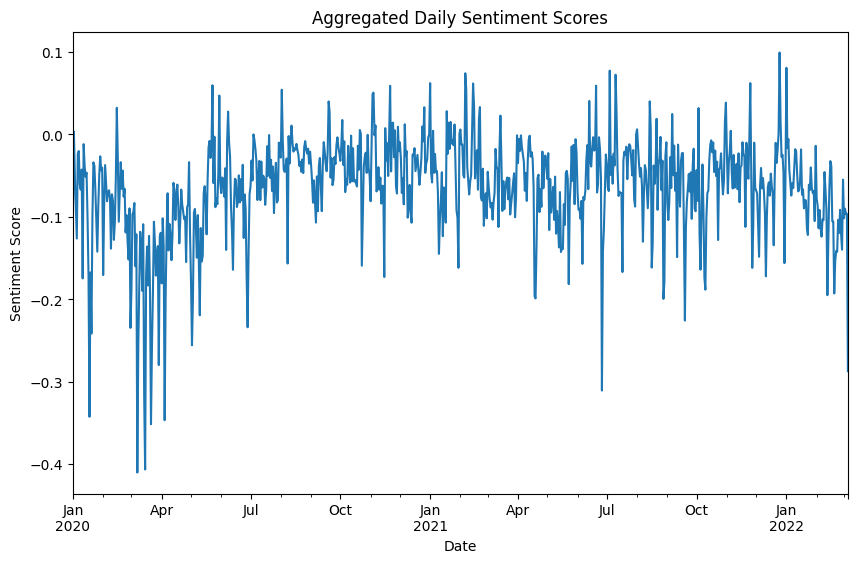

In [28]:
# Convert 'created_at' column to datetime
combined_df["created_at"] = pd.to_datetime(combined_df["created_at"])

# Resample sentiment scores on a daily basis
daily_sentiment = combined_df.set_index("created_at")["sentiment_score"].resample("D").mean()

# Plot the aggregated sentiment scores over time
plt.figure(figsize=(10, 6))
daily_sentiment.plot(title='Aggregated Daily Sentiment Scores')
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.show()

The WordCloud class from the wordcloud library is used to create visual representations of word frequency in a given text corpus. A word cloud is a graphical representation of text data in which the size of each word corresponds to its frequency or importance in the text. It's often used to visually emphasize the most frequently occurring words in a body of text

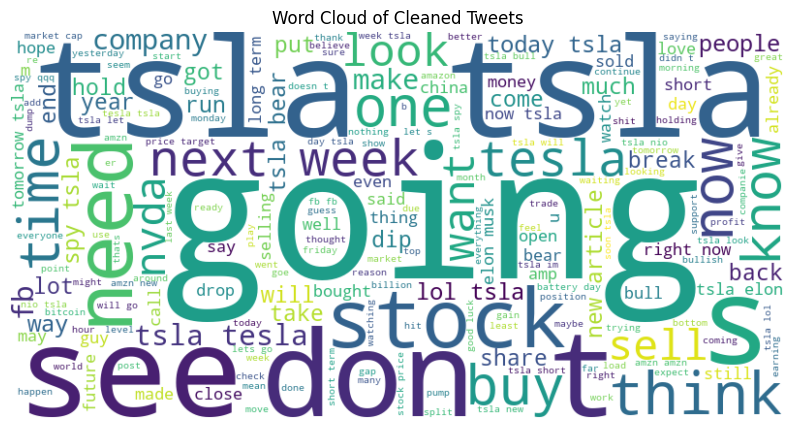

In [29]:
# Combine all cleaned tweets into a single string
all_tweets_text = ' '.join(combined_df['cleaned_body'])

# Generate a word cloud from the combined text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweets')
plt.show()

In [30]:


# Sample a smaller subset for testing (adjust the sample size as needed)
sample_size = 10000  # Adjust the sample size
data_sample = balanced_df.sample(n=sample_size, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_sample['cleaned_tweets'], data_sample['sentiment_score'], test_size=0.2, random_state=42
)

# Convert list of tokens back to string
X_train_strings = X_train.apply(lambda tokens: ' '.join(tokens))
X_test_strings = X_test.apply(lambda tokens: ' '.join(tokens))

# Convert text data into numerical features using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_strings)
X_test_vectorized = vectorizer.transform(X_test_strings)

# Build a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_vectorized)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')


Mean Squared Error: 0.21


In [31]:
# Convert regression scores to binary sentiment labels
y_pred_binary = [1 if score > 0.5 else 0 for score in y_pred]

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred_binary)

print("RandomForestRegressor accuracy:", rf_accuracy)


RandomForestRegressor accuracy: 0.827


In [32]:
# Build a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_vectorized)

# Convert regression scores to binary sentiment labels
y_pred_lr_binary = [1 if score > 0.5 else 0 for score in y_pred_lr]

# Calculate accuracy and classification report
lr_accuracy = accuracy_score(y_test, y_pred_lr_binary)
lr_classification_rep = classification_report(y_test, y_pred_lr_binary)

print("Linear Regression accuracy:", lr_accuracy)
print("Classification Report (Linear Regression):\n", lr_classification_rep)


Linear Regression accuracy: 0.8385
Classification Report (Linear Regression):
               precision    recall  f1-score   support

          -4       0.00      0.00      0.00         3
          -3       0.00      0.00      0.00         8
          -2       0.00      0.00      0.00        15
          -1       0.00      0.00      0.00       125
           0       0.82      0.99      0.90       848
           1       0.85      0.96      0.91       867
           2       0.00      0.00      0.00       109
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1

    accuracy                           0.84      2000
   macro avg       0.15      0.18      0.16      2000
weighted avg       0.72      0.84      0.77      2000



/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:

# Build a Naive Bayes Classifier model
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test_vectorized)

# Calculate accuracy and classification report
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_classification_rep = classification_report(y_test, y_pred_nb)

print("Naive Bayes Classifier accuracy:", nb_accuracy)
print("Classification Report (Naive Bayes Classifier):\n", nb_classification_rep)

Naive Bayes Classifier accuracy: 0.684
Classification Report (Naive Bayes Classifier):
               precision    recall  f1-score   support

          -4       0.00      0.00      0.00         3
          -3       0.00      0.00      0.00         8
          -2       0.00      0.00      0.00        15
          -1       0.33      0.02      0.03       125
           0       0.82      0.64      0.72       848
           1       0.62      0.95      0.75       867
           2       0.09      0.01      0.02       109
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1

    accuracy                           0.68      2000
   macro avg       0.17      0.15      0.14      2000
weighted avg       0.64      0.68      0.63      2000



/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
def preprocess_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_sample['cleaned_tweets'], data_sample['sentiment_score'], test_size=0.2, random_state=42
)

# Convert list of tokens back to string
X_train_strings = X_train.apply(lambda tokens: ' '.join(tokens))
X_test_strings = X_test.apply(lambda tokens: ' '.join(tokens))

# Convert text data into numerical features using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_strings)
X_test_vectorized = vectorizer.transform(X_test_strings)

# Build a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_vectorized)

# Convert regression scores to binary sentiment labels
y_pred_lr_binary = [1 if score > 0.5 else 0 for score in y_pred_lr]

# Calculate accuracy and classification report
lr_accuracy = accuracy_score(y_test, y_pred_lr_binary)
lr_classification_rep = classification_report(y_test, y_pred_lr_binary)

print("Linear Regression accuracy:", lr_accuracy)
print("Classification Report (Linear Regression):\n", lr_classification_rep)


Linear Regression accuracy: 0.8385
Classification Report (Linear Regression):
               precision    recall  f1-score   support

          -4       0.00      0.00      0.00         3
          -3       0.00      0.00      0.00         8
          -2       0.00      0.00      0.00        15
          -1       0.00      0.00      0.00       125
           0       0.82      0.99      0.90       848
           1       0.85      0.96      0.91       867
           2       0.00      0.00      0.00       109
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1

    accuracy                           0.84      2000
   macro avg       0.15      0.18      0.16      2000
weighted avg       0.72      0.84      0.77      2000



/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
new_tweet = "The pound is back above $1.26 after starting the week on a stronger footing, helped by the weaker US dollar"

# Preprocess the new tweet
cleaned_new_tweet = preprocess_tweet(new_tweet)

# Convert the cleaned tweet into a vector using CountVectorizer
new_tweet_vectorized = vectorizer.transform([cleaned_new_tweet])

# Predict sentiment using the Linear Regression model
prediction = lr_model.predict(new_tweet_vectorized)

# Determine sentiment label
threshold = 0.3  #  desired threshold value

sentiment_label = "positive" if prediction[0] > threshold else "negative"

print(f"The model's sentiment prediction for the new tweet is: {sentiment_label}")

The model's sentiment prediction for the new tweet is: positive


In [36]:
# Define the list of tickers (company symbols) for which you want to retrieve stock price data
tickers = ["TSLA", "AAPL", "AMZN","META"]  # Adjust as needed

# Define the date range for historical data
start_date = '2019-01-01'
end_date = '2022-12-31'

# Fetch historical stock price data from Yahoo Finance
stock_prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Reset the index to include the 'Date' column
stock_prices = stock_prices.reset_index()

# Print the first few rows of the retrieved stock price data
stock_prices.head()

[*********************100%%**********************]  4 of 4 completed


,Date,AAPL,AMZN,META,TSLA
0,2019-01-02,37.893326,76.956497,135.679993,20.674667
1,2019-01-03,34.118874,75.014000,131.740005,20.024000
2,2019-01-04,35.575390,78.769501,137.949997,21.179333
3,2019-01-07,35.496197,81.475502,138.050003,22.330667
4,2019-01-08,36.172874,82.829002,142.529999,22.356667


Merging Sentiment Scores and Stock Price Data

In [37]:
stock_prices['Date'] = pd.to_datetime(stock_prices['Date']).dt.tz_localize(None)  # Remove timezone information

In [38]:
merged_data = pd.merge(balanced_df, stock_prices, left_index=True, right_index=True, how='left')

In [51]:
# Convert 'created_at' column to datetime
combined_df['created_at'] = pd.to_datetime(combined_df['created_at'])

# Convert 'Date' column in stock_prices to UTC datetime
stock_prices['Date'] = pd.to_datetime(stock_prices['Date']).dt.tz_localize(None)

# Merge sentiment scores with stock price data based on the index
merged_data = pd.merge(combined_df, stock_prices, left_index=True, right_index=True, how='left')

# Dictionary to map old ticker names to new ones
ticker_mapping = {'AAPL': 'AAPL', 'TSLA': 'TSLA', 'AMZN': 'AMZN', 'FB': 'META'}

# Calculate correlations for each stock
for old_ticker, new_ticker in ticker_mapping.items():
    correlation = merged_data['sentiment_score'].corr(merged_data[new_ticker])
    print(f"Correlation between sentiment scores and {new_ticker} stock price movements: {correlation:.2f}")



Correlation between sentiment scores and AAPL stock price movements: -0.05
Correlation between sentiment scores and TSLA stock price movements: -0.05
Correlation between sentiment scores and AMZN stock price movements: -0.07
Correlation between sentiment scores and META stock price movements: -0.10


Lag Features: Create lagged versions of stock price movements or other relevant variables. For instance, you can create lag features of the sentiment score to account for delayed market reactions.

Technical Indicators: Calculate common technical indicators such as moving averages, Relative Strength Index (RSI), and Bollinger Bands. These indicators can capture trends and patterns in stock price movements.

Market Volatility Measures: Include volatility indicators such as the Average True Range (ATR) or historical volatility to capture market volatility during different periods.

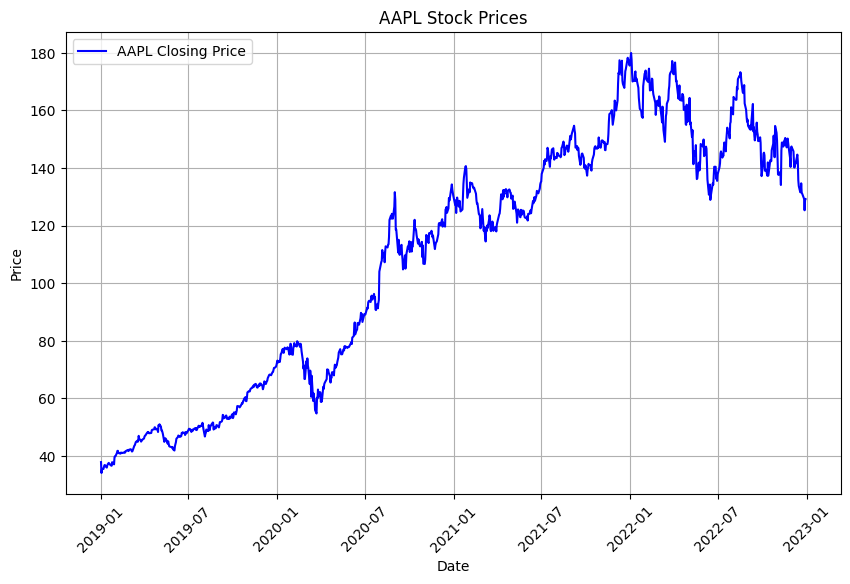

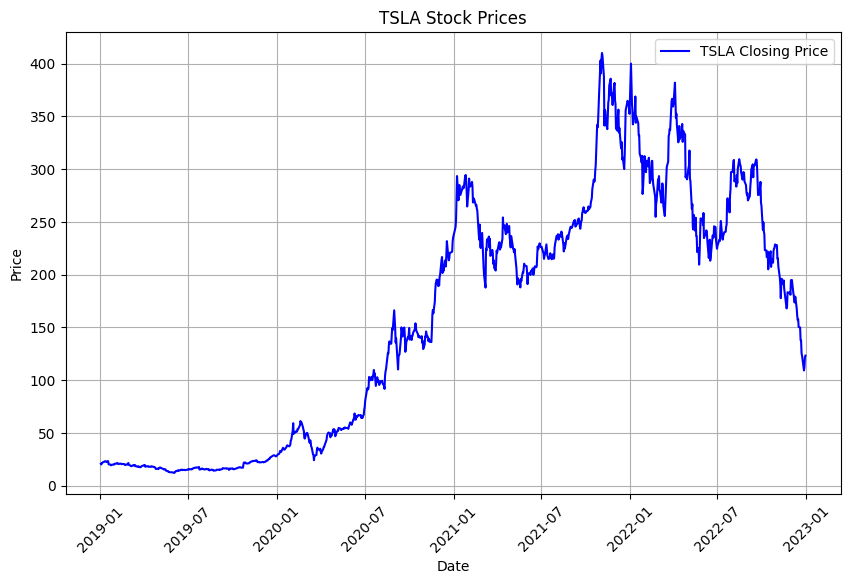

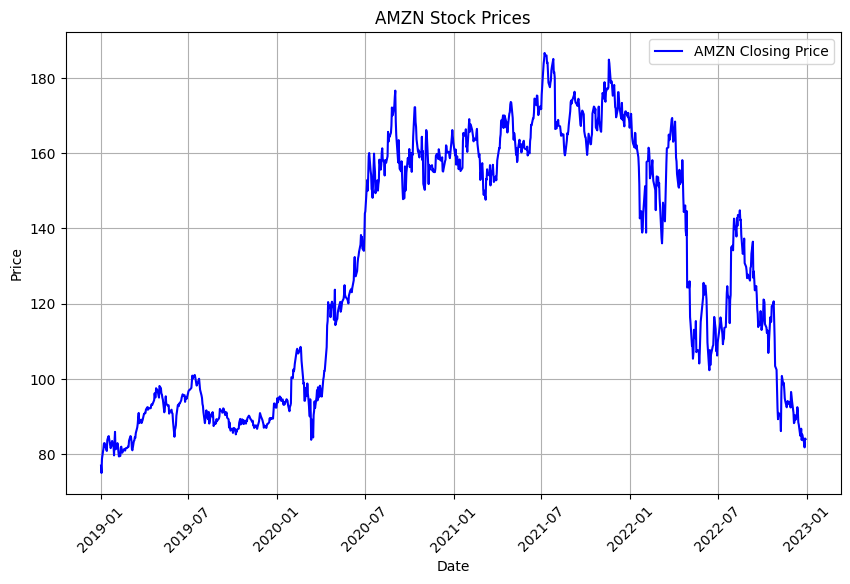

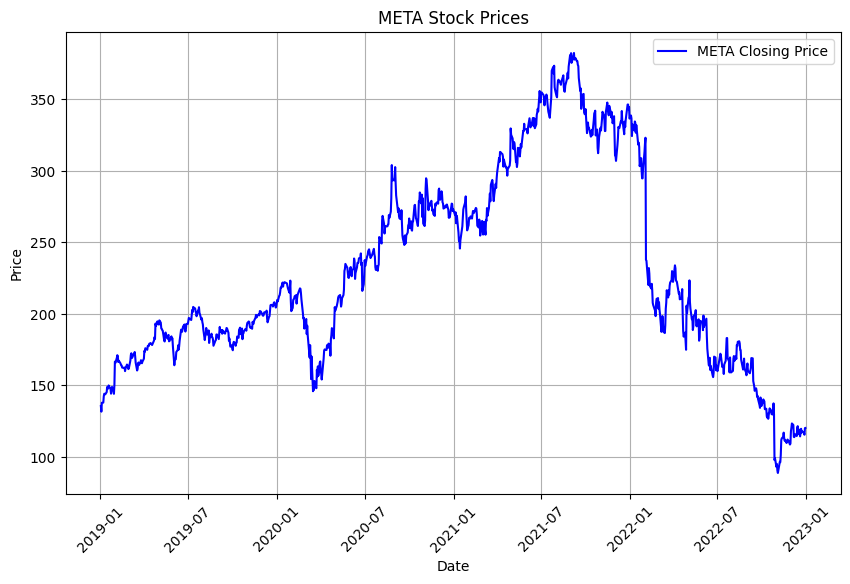

In [43]:
# Plotting historical trends of stock prices without 50-day moving average
ticker_mapping = {'AAPL': 'AAPL', 'TSLA': 'TSLA', 'AMZN': 'AMZN', 'FB': 'META'}
for ticker in ticker_mapping.values():
    plt.figure(figsize=(10, 6))

    plt.plot(merged_data['Date'], merged_data[ticker],
             label=f'{ticker} Closing Price', color='blue')

    plt.title(f'{ticker} Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show()